# Firm Level Innovation and CEO Compensation


Using the panel data on US patents from 1992-2006 and the data on granted stock options value for the Chief Executive Office (CEO) in matched US firms, this study aims to investigate the relationship between the value of CEO’s granted stock options and the firm-level innovation activity, measured by number of patent granted each year.This study aims to provide empirical evidence for Manso(2011)’s theory, which predicts that
the optimal-motivating incentive scheme exhibits a substantial tolerance for the early failure,
the reward for long-term success and the commitment to a long-term compensation plan for
CEOs by board of directors

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import qeds

from sklearn.linear_model import LinearRegression
import seaborn as sns

%matplotlib inline

## Data Cleaning

The primary data in this study comes from the [National Bureau of Economic Research (NBER) Patent Database](https://sites.google.com/site/patentdataproject/Home/downloads) and Wharton Research Data Service (WRDS) Compustat Executive Compensation Database.

### Patent Data 

Patent data `patsic06_mar09_ip.csv` contains informtion regarding the application and granted year, US patent class, along with all the original IPCs for the patent, the original assignee number, and all the pdpass numbers that result from splitting jointly owned patents, standardizing names, etc.

In [2]:
import csv
pats = pd.read_csv("/home/jupyter/494 Thesis/patsic06_mar09_ip.csv")
pats.head()

,appyear,assignee,cat,gyear,icl_class,icl_maingroup,nclass,patent,pdpass,subcat,subclass
0,1974,251415.0,6.0,1976,A41D,19.0,2,3930271,10030271.0,63.0,161.0
1,1974,246000.0,6.0,1976,A47D,7.0,5,3930272,10156902.0,65.0,11.0
2,1975,10490.0,6.0,1976,A47C,21.0,5,3930273,10112031.0,65.0,331.0
3,1975,10490.0,6.0,1976,A47D,7.0,5,3930273,10112031.0,65.0,331.0
4,1974,0.0,5.0,1976,B63B,7.0,114,3930274,NaN,55.0,2.0


#### Variable Description
  
* Patent data
  
`appyear` records the year when the patent is filed and applied; `gyear` is the year when a patent is granted. Each granted patent has a unique patent number as `patent`.  
  
`cat`, `icl_class`, `icl_maingroup`, `nclass`, `subcat`, `subclass` are patent class or technology class of each patent, which are less relevant in my study
  
* Assignee identifier
  
`assignee` is the number assigned to a company when applying or granting a patent, originally created by the United States Patent Office (U.S.P.O). `pdpass` is also a unique assignee number and it is used to match data to the Compustat. One `pdpass` might be assigned by multiple `assignee` numbers 



  
#### Treatment of Unmatched assignee 
  
There are patents which are not matched to the assignee by the name matching algorith developed by the NBER Patent database, these observations are shown as `assignee = 0` or `pdpass = NaN`. These observation are automatically dropped 

In [3]:
# observations with pdpass not missing 
pats = pats[pats['pdpass'].notnull()]

# count number of unique patent numbers to have patent count for a assignee in a year
pat_yc1 = pats.groupby(["pdpass","gyear"])["patent"].nunique().to_frame().reset_index()\
.rename(columns={"patent":"patent_count"})

pat_yc1.head()

,pdpass,gyear,patent_count
0,6361394.0,1979,6
1,6363799.0,1976,4
2,6363799.0,1977,3
3,6363799.0,1978,4
4,6363799.0,1979,5


In [4]:
pat_yc1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 570089 entries, 0 to 570088
Data columns (total 3 columns):
pdpass          570089 non-null float64
gyear           570089 non-null int64
patent_count    570089 non-null int64
dtypes: float64(1), int64(2)
memory usage: 13.0 MB


#### Add `gvkey`
  
`gvkey` is Wharton Rearch Data Service (WRDS)'s identifier of companies

`dynasscsv.csv` keeps record of all dynamic change in patent ownership. Change in patent ownership may arise from merge and acquisition of companies, or sale of patent. In this study, I only focus on the original assignee (as `pdpco1` and `gvkey1`) of the patent and disregard any dynamic change in patent ownership. This is because I am more interested in the relationship between patent and compensation through executive's decision on company's own research project and the process of exploring new ideas, not through purchasing patent or acquire patents from other companies, as patent purchase is a decision with known payoffs      

In [5]:
dynass = pd.read_csv("/home/jupyter/494 Thesis/dynasscsv.csv")
dynass = dynass[["pdpass","pdpco1","gvkey1"]] 
dynass = dynass.rename(columns = {"pdpco1":"pdpco", "gvkey1":"gvkey"})
dynass = dynass.astype({"pdpass": float})
dynass.head()

,pdpass,pdpco,gvkey
0,-19702.0,66448,66448
1,-19541.0,121844,121844
2,-19540.0,121844,121844
3,-19291.0,62613,62613
4,-19289.0,176118,176118


In many cases, `pdpass` equals `gvkey` for a company. My goal is to have `gvkey` as the unqie identifier for companies, thus I drop any `pdpass` that is not matched to a `gvkey`, thus I perform the inner merge. In addition, we would like to investigate any change in patent count after executives granted any stock options; since data range for executives' stock option is from 1992-2006, we would only focus on the subset of patent count that is after 1992  

In [6]:
pgvkey = pd.merge(pat_yc1, dynass, on="pdpass",how="inner")

# align with executive compensation data (1992 onwards)
pgvkey1 = pgvkey.loc[pgvkey["gyear"]>=1992]
pgvkey1.head()

,pdpass,gyear,patent_count,pdpco,gvkey
4,10030467.0,2006,1,8006,8006
18,10030734.0,1992,4,1847,1847
19,10030734.0,1994,5,1847,1847
20,10030734.0,1995,2,1847,1847
21,10030734.0,1996,4,1847,1847


#### Treating Missing Year's Patent Count
  
For each company (as identified by gvkey), the reason for missing value in the patent count can be: 1) there might be patents granted in that year, however they are not matched to the pdpass, and thus not to the company in the NBER patent database; 2) there is simply no patent granted in that year. As a result, the rule of thumb of treating patent count missing value each year is simply replace it with 0 in this study  

In [7]:
pgvkey2 = pgvkey1[["gvkey","gyear","patent_count"]]
pgvkey3 = pgvkey2.pivot_table(index="gvkey", columns ="gyear", values="patent_count",
                             aggfunc= "sum")
pgvkey3.head()

gyear,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006
gvkey,,,,,,,,,,,,,,,
1004,1.0,3.0,1.0,3.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN
1010,3.0,3.0,6.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1012,NaN,2.0,NaN,2.0,2.0,NaN,1.0,NaN,NaN,3.0,NaN,3.0,NaN,NaN,2.0
1013,9.0,15.0,12.0,12.0,9.0,10.0,10.0,23.0,23.0,47.0,69.0,100.0,97.0,82.0,83.0
1016,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
pgvkey3 = pgvkey3.stack("gyear",dropna=False).to_frame().reset_index()\
    .rename(columns={0: 'patent_count'})
pgvkey3.head()

,gvkey,gyear,patent_count
0,1004,1992,1.0
1,1004,1993,3.0
2,1004,1994,1.0
3,1004,1995,3.0
4,1004,1996,NaN


In [9]:
pgvkey3["patent_count"] = pgvkey3["patent_count"].fillna(0)
pgvkey3.head()

,gvkey,gyear,patent_count
0,1004,1992,1.0
1,1004,1993,3.0
2,1004,1994,1.0
3,1004,1995,3.0
4,1004,1996,0.0


In [10]:
pgvkey3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88365 entries, 0 to 88364
Data columns (total 3 columns):
gvkey           88365 non-null int64
gyear           88365 non-null int64
patent_count    88365 non-null float64
dtypes: float64(1), int64(2)
memory usage: 2.0 MB


### Compustate Executive Compensation - Stock Option Granted

`stock_option.csv` contains data on the Black-Sholes value of stock option granted by the company's executives 1992-2006. It has two sets of variables, one describes the executive information, such as:

* reload = reload option (1 = if executive exercised reload option)
* year = year when stock option is granted 
* pceo = description of the executive's position
* blkshval = Black-Scholes value of the stock option ...

Another set of variables describes the charateristics of the company, for example:
* value = company value
* ticker = company ticker
* sic = Standard Industry Classification code ...
  
As I will show later, in this study, I willl only look into the stock options value granted by the CEOs of the company (as categorized in `pceo` variable). I will sum the *Black-Scholes values* of the stock option in a given year for a CEO (plus reloaded stock option values, if any) to produce the measure of CEO's incentive compensation

In [11]:
stockog= pd.read_csv("/home/jupyter/494 Thesis/stock_option.csv")

# change column names to lower case
stockog.columns = [x.lower() for x in stockog.columns]

In [12]:
# having compensation for the CEOs only
stockog = stockog.loc[pd.notnull(stockog["pceo"])]
stockog.head()

,reload,co_per_rol,grntnum,numsecur,pcttotopt,mktpric,expric,pcdvalue,value,blkshval,exdate,year,pceo,gvkey,cusip,sicdesc,naicsdesc,ticker,naics,sic
1,0,5623,1,60.000,24.00,13.750,13.750,5 PERCENT,518.838,288.811,20050117.0,1994,CEO,1004,36110,MACHINERY AND EQUIPMENT-WHSL,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080
6,0,5623,1,75.000,26.05,17.500,17.500,5 PERCENT,825.424,325.076,20051011.0,1995,CEO,1004,36110,MACHINERY AND EQUIPMENT-WHSL,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080
17,0,5623,1,200.000,32.08,20.000,20.000,5 PERCENT,2515.578,1133.373,20060709.0,1996,CEO,1004,36110,MACHINERY AND EQUIPMENT-WHSL,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080
18,1,5623,2,7.768,1.24,25.875,25.875,5 PERCENT,43.316,37.718,20001010.0,1996,CEO,1004,36110,MACHINERY AND EQUIPMENT-WHSL,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080
19,1,5623,3,5.371,0.86,25.875,25.875,5 PERCENT,38.396,29.110,20011009.0,1996,CEO,1004,36110,MACHINERY AND EQUIPMENT-WHSL,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080


In [13]:
# sum of stock option and reload stock option 
stockog1 = stockog.groupby(["gvkey","year"])["blkshval"].sum().to_frame().reset_index()
stockog1.head()

,gvkey,year,blkshval
0,1004,1994,288.811
1,1004,1995,325.076
2,1004,1996,1443.320
3,1004,1997,2528.623
4,1004,1998,1644.472


#### Treating Missing Values

In [14]:
# filling in missing years and keep them as missing

stockog2 = stockog1.pivot_table(index="gvkey", columns ="year", values="blkshval")
stockog2 = stockog2.stack("year",dropna=False).to_frame().reset_index().rename(
    columns={0: 'blkshval'})
stockog2.head()

,gvkey,year,blkshval
0,1004,1992,NaN
1,1004,1993,NaN
2,1004,1994,288.811
3,1004,1995,325.076
4,1004,1996,1443.320


### Merged Dataset

In [15]:
patcom = pd.merge(pgvkey3, stockog2, left_on=["gvkey","gyear"], right_on=["gvkey","year"], 
                  how="inner")
patcom.head()

,gvkey,gyear,patent_count,year,blkshval
0,1004,1992,1.0,1992,NaN
1,1004,1993,3.0,1993,NaN
2,1004,1994,1.0,1994,288.811
3,1004,1995,3.0,1995,325.076
4,1004,1996,0.0,1996,1443.320


#### Restore Firm Charateristics 
  
All company's descriptive variables are restored by merging `stockog1` dataframe with the original dataframe, since these variables will be candiate control variables for dealing with endogeneity problem and omitted variable bias. For example: 

* value = company value
* sic = Standard Industry Classification 
  
  etc...

We drop variable `year` and `blkshval` to avoid creating repetitive columns for year and blkshval when merging 

In [17]:
stockog3 = stockog.drop_duplicates(subset=["gvkey","year"], 
                                   keep="first").drop(columns=["blkshval"])
stockog3.head()

,reload,co_per_rol,grntnum,numsecur,pcttotopt,mktpric,expric,pcdvalue,value,exdate,year,pceo,gvkey,cusip,sicdesc,naicsdesc,ticker,naics,sic
1,0,5623,1,60.0,24.00,13.75,13.75,5 PERCENT,518.838,20050117.0,1994,CEO,1004,36110,MACHINERY AND EQUIPMENT-WHSL,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080
6,0,5623,1,75.0,26.05,17.50,17.50,5 PERCENT,825.424,20051011.0,1995,CEO,1004,36110,MACHINERY AND EQUIPMENT-WHSL,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080
17,0,5623,1,200.0,32.08,20.00,20.00,5 PERCENT,2515.578,20060709.0,1996,CEO,1004,36110,MACHINERY AND EQUIPMENT-WHSL,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080
53,0,5623,1,150.0,16.84,23.50,23.50,5 PERCENT,2216.854,20070714.0,1997,CEO,1004,36110,MACHINERY AND EQUIPMENT-WHSL,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080
75,0,5623,1,195.0,23.59,23.50,23.50,5 PERCENT,2363.166,20090101.0,1998,CEO,1004,36110,MACHINERY AND EQUIPMENT-WHSL,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080


In [18]:
pat_full = pd.merge(patcom, stockog3, left_on=["gvkey","year"],right_on=["gvkey","year"], how="left")
pat_full.head()

,gvkey,gyear,patent_count,year,blkshval,reload,co_per_rol,grntnum,numsecur,pcttotopt,...,pcdvalue,value,exdate,pceo,cusip,sicdesc,naicsdesc,ticker,naics,sic
0,1004,1992,1.0,1992,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1004,1993,3.0,1993,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1004,1994,1.0,1994,288.811,0.0,5623.0,1.0,60.0,24.00,...,5 PERCENT,518.838,20050117.0,CEO,36110,MACHINERY AND EQUIPMENT-WHSL,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080.0
3,1004,1995,3.0,1995,325.076,0.0,5623.0,1.0,75.0,26.05,...,5 PERCENT,825.424,20051011.0,CEO,36110,MACHINERY AND EQUIPMENT-WHSL,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080.0
4,1004,1996,0.0,1996,1443.320,0.0,5623.0,1.0,200.0,32.08,...,5 PERCENT,2515.578,20060709.0,CEO,36110,MACHINERY AND EQUIPMENT-WHSL,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080.0


For some observations, we lost company charatertistics when merging the data, for example `cusip`, `sicdesc` and we would like to restore these details. Here, I would only restore `sic` and use it to classify each company by its industry. I perform by conducting a groupby missing value filling. 

In [19]:
# groupby filling missing values

pat_full['sic'] = pat_full.groupby(['gvkey'])['sic'].ffill()
pat_full['sic'] = pat_full.groupby(['gvkey'])['sic'].bfill()

pat_full.head()

,gvkey,gyear,patent_count,year,blkshval,reload,co_per_rol,grntnum,numsecur,pcttotopt,...,pcdvalue,value,exdate,pceo,cusip,sicdesc,naicsdesc,ticker,naics,sic
0,1004,1992,1.0,1992,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5080.0
1,1004,1993,3.0,1993,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5080.0
2,1004,1994,1.0,1994,288.811,0.0,5623.0,1.0,60.0,24.00,...,5 PERCENT,518.838,20050117.0,CEO,36110,MACHINERY AND EQUIPMENT-WHSL,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080.0
3,1004,1995,3.0,1995,325.076,0.0,5623.0,1.0,75.0,26.05,...,5 PERCENT,825.424,20051011.0,CEO,36110,MACHINERY AND EQUIPMENT-WHSL,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080.0
4,1004,1996,0.0,1996,1443.320,0.0,5623.0,1.0,200.0,32.08,...,5 PERCENT,2515.578,20060709.0,CEO,36110,MACHINERY AND EQUIPMENT-WHSL,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080.0


In [20]:
pat_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12915 entries, 0 to 12914
Data columns (total 22 columns):
gvkey           12915 non-null int64
gyear           12915 non-null int64
patent_count    12915 non-null float64
year            12915 non-null int64
blkshval        3905 non-null float64
reload          3905 non-null float64
co_per_rol      3905 non-null float64
grntnum         3905 non-null float64
numsecur        3905 non-null float64
pcttotopt       3885 non-null float64
mktpric         3903 non-null float64
expric          3903 non-null float64
pcdvalue        3876 non-null object
value           3870 non-null float64
exdate          3898 non-null float64
pceo            3905 non-null object
cusip           3905 non-null object
sicdesc         3905 non-null object
naicsdesc       3585 non-null object
ticker          3905 non-null object
naics           3585 non-null float64
sic             12915 non-null float64
dtypes: float64(13), int64(3), object(6)
memory usage: 2.3+ MB

Before going to visualization, we would like to aggregate `sic` into larger industry groups. According to [SIC classification](https://en.wikipedia.org/wiki/Standard_Industrial_Classification), SIC classify companies into 10 major categories, i.e. Agriculture, Forestry and Fishing, Mining, Construction, etc.

In [21]:
pat_full['sector'] = pd.cut(pat_full['sic'], 
                            bins=[100, 999, 1499, 1999, 3999, 4999, 5199, 5999, 6799, 8999, 9729], 
                            labels=['Agriculture, Forestry and Fishing', 'Mining', 'Construction',
                                    'Manufacturing','Transportation, Communications and Utility',
                                    'Wholesale Trade','Retail Trade','Finance, Insurance and Real Estate',
                                    'Services','Public Administration'])
pat_full.head()

,gvkey,gyear,patent_count,year,blkshval,reload,co_per_rol,grntnum,numsecur,pcttotopt,...,value,exdate,pceo,cusip,sicdesc,naicsdesc,ticker,naics,sic,sector
0,1004,1992,1.0,1992,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5080.0,Wholesale Trade
1,1004,1993,3.0,1993,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5080.0,Wholesale Trade
2,1004,1994,1.0,1994,288.811,0.0,5623.0,1.0,60.0,24.00,...,518.838,20050117.0,CEO,36110,MACHINERY AND EQUIPMENT-WHSL,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080.0,Wholesale Trade
3,1004,1995,3.0,1995,325.076,0.0,5623.0,1.0,75.0,26.05,...,825.424,20051011.0,CEO,36110,MACHINERY AND EQUIPMENT-WHSL,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080.0,Wholesale Trade
4,1004,1996,0.0,1996,1443.320,0.0,5623.0,1.0,200.0,32.08,...,2515.578,20060709.0,CEO,36110,MACHINERY AND EQUIPMENT-WHSL,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080.0,Wholesale Trade


As we can see below, there are no observations for companies in Public Administration and Agriculture in this merged datase

In [21]:
pat_full.loc[pat_full['sector']=='Public Administration']

,gvkey,gyear,patent_count,year,blkshval,reload,co_per_rol,grntnum,numsecur,pcttotopt,...,value,exdate,pceo,cusip,sicdesc,naicsdesc,ticker,naics,sic,sector


In [22]:
pat_full.loc[pat_full['sector']=='Agriculture, Forestry and Fishing']

,gvkey,gyear,patent_count,year,blkshval,reload,co_per_rol,grntnum,numsecur,pcttotopt,...,value,exdate,pceo,cusip,sicdesc,naicsdesc,ticker,naics,sic,sector


## **Visualiztion**

##### Mean Measure of Company Value/Patent Count/Stock Option Value for Each Industry

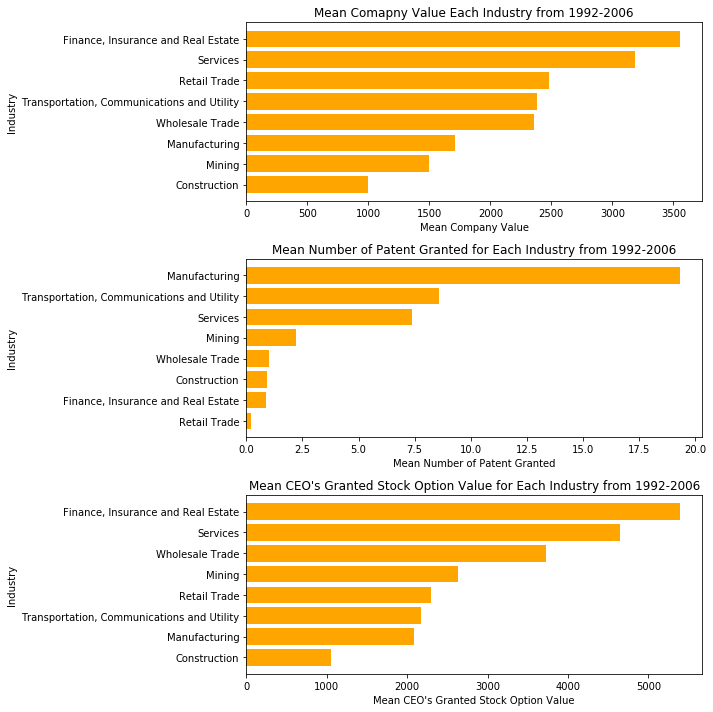

In [23]:
vsec_mean = pat_full.groupby(['sector'])['value'].mean().sort_values() # mean company value
psec_mean = pat_full.groupby(['sector'])['patent_count'].mean().sort_values() # mean patent count
stsec_mean = pat_full.groupby(['sector'])['blkshval'].mean().sort_values() # mean CEO's stock option value



fig, ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].barh(vsec_mean.index, vsec_mean.values, color='orange')

ax[0].set_xlabel("Mean Company Value")
ax[0].set_ylabel( "Industry")
ax[0].set_title("Mean Comapny Value Each Industry from 1992-2006")

ax[1].barh(psec_mean.index, psec_mean.values, color='orange')

ax[1].set_xlabel("Mean Number of Patent Granted")
ax[1].set_ylabel( "Industry")
ax[1].set_title("Mean Number of Patent Granted for Each Industry from 1992-2006")

ax[2].barh(stsec_mean.index, stsec_mean.values, color='orange')

ax[2].set_xlabel("Mean CEO's Granted Stock Option Value")
ax[2].set_ylabel( "Industry")
ax[2].set_title("Mean CEO's Granted Stock Option Value for Each Industry from 1992-2006")


fig.tight_layout()

#### Trend in patent data and value of CEO's granted stock option

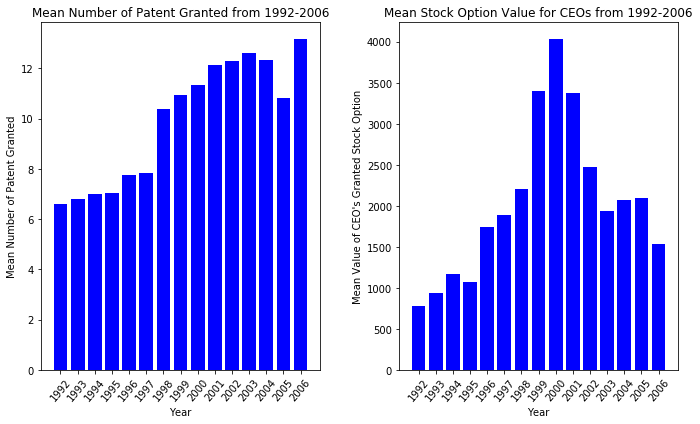

In [22]:
pc_mean = pgvkey3.groupby(["gyear"])["patent_count"].mean()
stockog3 = stockog2.groupby(["year"])["blkshval"].mean()

fig, ax = plt.subplots(1,2, figsize=(10, 6))
ax[0].bar(range(pc_mean.shape[0]), pc_mean.values, color="blue")
ax[1].bar(range(stockog3.shape[0]), stockog3.values, color="blue")

# xtickes labels
ax[0].set_xticks(range(pc_mean.shape[0]))
ax[0].set_xticklabels(pc_mean.index, rotation=50,fontsize=10)
ax[1].set_xticks(range(stockog3.shape[0]))
ax[1].set_xticklabels(stockog3.index, rotation=50,fontsize=10)

# x-axis label
ax[0].set_ylabel("Mean Number of Patent Granted")
ax[0].set_xlabel( "Year")
ax[0].set_title("Mean Number of Patent Granted from 1992-2006")
ax[1].set_ylabel("Mean Value of CEO's Granted Stock Option")
ax[1].set_xlabel( "Year")
ax[1].set_title("Mean Stock Option Value for CEOs from 1992-2006")

fig.tight_layout()

## Regression

All patents are granted from United States Patent Office (USPO): the average pendency of a utility non-provisional patent application to final disposal is approximately 25.7 months (this is also evident in the data). I will examine the relationship between patent count for a 3-year lagged measure of CEO's granted stock option value. Selection of 3-year as the time lag seems arbitrary, as a result, I will perform another specification where I use 5-year as the time lag. Furthermore, due to the average pendency of the patent process, it's a natural placebo test to have in this study where I use the same-year CEO's stock option value and we should not expect any significant result in this specification. Summary of specifications is as follows:

* Same-year CEO's granted stock option as independent variable (placebo test) - Specification 1
* 3-year lagged measure CEO's granted stock option as independent variable (baseline regression) - Specification 2
* 5-year lagged measure CEO's granted stock option as independent variable - Specification 3

#### Empirical Evidence on Average Pendency of Patent Application Process

In [23]:
pats.groupby(["appyear","gyear"]).nunique()["patent"].nlargest(10)

appyear  gyear
1997     1999     66991
1999     2001     61859
1996     1998     61361
2000     2002     61203
1998     2000     61117
2001     2003     60241
2002     2004     57828
1995     1997     50220
1994     1996     45368
2003     2006     41728
Name: patent, dtype: int64

In [24]:
pats['pendency'] = pats['gyear']-pats['appyear']
pats['pendency'].describe()

count    4.176878e+06
mean     2.208581e+00
std      1.197069e+00
min      0.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      3.000000e+00
max      3.600000e+01
Name: pendency, dtype: float64

#### Create Lagged Measured of CEO's Granted Stock Option

In [25]:
# shift the blkshval and concat it to our original dataset

time = 3 # 3-year lagged mesure

blkshval3 = pat_full.groupby(["gvkey"])["blkshval"].shift(time).to_frame().rename(columns={"blkshval":"blkshval3"})
patlg_full = pd.concat([pat_full,blkshval3], axis=1)

lag = 2 # 5-year lagged measure
blkshval5 = pat_full.groupby(["gvkey"])["blkshval"].shift(time+lag).to_frame().rename(columns={"blkshval":"blkshval5"})
patlg_full1 = pd.concat([patlg_full,blkshval5], axis=1)

patlg_full1.head(7)

,gvkey,gyear,patent_count,year,blkshval,reload,co_per_rol,grntnum,numsecur,pcttotopt,...,pceo,cusip,sicdesc,naicsdesc,ticker,naics,sic,sector,blkshval3,blkshval5
0,1004,1992,1.0,1992,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5080.0,Wholesale Trade,NaN,NaN
1,1004,1993,3.0,1993,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5080.0,Wholesale Trade,NaN,NaN
2,1004,1994,1.0,1994,288.811,0.0,5623.0,1.0,60.0,24.00,...,CEO,36110,MACHINERY AND EQUIPMENT-WHSL,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080.0,Wholesale Trade,NaN,NaN
3,1004,1995,3.0,1995,325.076,0.0,5623.0,1.0,75.0,26.05,...,CEO,36110,MACHINERY AND EQUIPMENT-WHSL,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080.0,Wholesale Trade,NaN,NaN
4,1004,1996,0.0,1996,1443.320,0.0,5623.0,1.0,200.0,32.08,...,CEO,36110,MACHINERY AND EQUIPMENT-WHSL,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080.0,Wholesale Trade,NaN,NaN
5,1004,1997,0.0,1997,2528.623,0.0,5623.0,1.0,150.0,16.84,...,CEO,36110,MACHINERY AND EQUIPMENT-WHSL,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080.0,Wholesale Trade,288.811,NaN
6,1004,1998,0.0,1998,1644.472,0.0,5623.0,1.0,195.0,23.59,...,CEO,36110,MACHINERY AND EQUIPMENT-WHSL,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080.0,Wholesale Trade,325.076,NaN


Creating lagged measure of CEO's granted stock option value generates additional missing values as earliest data we have is 1992. To increase the quality of my dataset, I will adjust the year range of our merged dataset to 1995-2006 in line with our baseline regression; and filter out companies with more than 5 missing values of blkshval (5 missing years) over the period of 1995-2006 

#### Adjust year range

For our baseline regression, where I use 3-year lagged measure of CEO's stock option value, since year range for our the independent variable, CEO stock option is from 1992 to 2006, the earliest year for patent count would be from 1995. Adjusted year range for independent and dependent variables:  
* CEO's stock option: 1992-2003 (this is automatically adjusted when shifting the data)
* Patent count: 1995-2006


In [26]:
patlgg_full1 = patlg_full1.loc[patlg_full["gyear"]>=(1992+time)]
patlgg_full1.head()

,gvkey,gyear,patent_count,year,blkshval,reload,co_per_rol,grntnum,numsecur,pcttotopt,...,pceo,cusip,sicdesc,naicsdesc,ticker,naics,sic,sector,blkshval3,blkshval5
3,1004,1995,3.0,1995,325.076,0.0,5623.0,1.0,75.0,26.05,...,CEO,36110,MACHINERY AND EQUIPMENT-WHSL,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080.0,Wholesale Trade,NaN,NaN
4,1004,1996,0.0,1996,1443.320,0.0,5623.0,1.0,200.0,32.08,...,CEO,36110,MACHINERY AND EQUIPMENT-WHSL,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080.0,Wholesale Trade,NaN,NaN
5,1004,1997,0.0,1997,2528.623,0.0,5623.0,1.0,150.0,16.84,...,CEO,36110,MACHINERY AND EQUIPMENT-WHSL,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080.0,Wholesale Trade,288.811,NaN
6,1004,1998,0.0,1998,1644.472,0.0,5623.0,1.0,195.0,23.59,...,CEO,36110,MACHINERY AND EQUIPMENT-WHSL,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080.0,Wholesale Trade,325.076,NaN
7,1004,1999,0.0,1999,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5080.0,Wholesale Trade,1443.320,288.811


#### Filter Company with too many missing values

There are too many missing values in `blkshval` measure, we would like to filter companies with too many missing values to reduce the noise  

In [27]:
pat35 = patlgg_full1.loc[patlgg_full1.groupby(['gvkey'])['blkshval'].filter(lambda x: len(x[pd.isnull(x)])< 5).index]
pat35.head(10)

,gvkey,gyear,patent_count,year,blkshval,reload,co_per_rol,grntnum,numsecur,pcttotopt,...,pceo,cusip,sicdesc,naicsdesc,ticker,naics,sic,sector,blkshval3,blkshval5
3,1004,1995,3.0,1995,325.076,0.0,5623.0,1.0,75.000,26.05,...,CEO,36110,MACHINERY AND EQUIPMENT-WHSL,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080.0,Wholesale Trade,NaN,NaN
4,1004,1996,0.0,1996,1443.320,0.0,5623.0,1.0,200.000,32.08,...,CEO,36110,MACHINERY AND EQUIPMENT-WHSL,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080.0,Wholesale Trade,NaN,NaN
5,1004,1997,0.0,1997,2528.623,0.0,5623.0,1.0,150.000,16.84,...,CEO,36110,MACHINERY AND EQUIPMENT-WHSL,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080.0,Wholesale Trade,288.811,NaN
6,1004,1998,0.0,1998,1644.472,0.0,5623.0,1.0,195.000,23.59,...,CEO,36110,MACHINERY AND EQUIPMENT-WHSL,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080.0,Wholesale Trade,325.076,NaN
7,1004,1999,0.0,1999,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5080.0,Wholesale Trade,1443.320,288.811
8,1004,2000,1.0,2000,2825.003,0.0,5623.0,1.0,600.000,48.53,...,CEO,36110,MACHINERY AND EQUIPMENT-WHSL,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080.0,Wholesale Trade,2528.623,325.076
9,1004,2001,0.0,2001,1280.686,0.0,5623.0,1.0,175.473,27.55,...,CEO,36110,MACHINERY AND EQUIPMENT-WHSL,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080.0,Wholesale Trade,1644.472,1443.320
10,1004,2002,0.0,2002,1267.923,0.0,5623.0,1.0,280.000,29.68,...,CEO,36110,MACHINERY AND EQUIPMENT-WHSL,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080.0,Wholesale Trade,NaN,2528.623
11,1004,2003,1.0,2003,2668.131,0.0,5623.0,1.0,356.393,23.38,...,CEO,36110,MACHINERY AND EQUIPMENT-WHSL,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080.0,Wholesale Trade,2825.003,1644.472
12,1004,2004,0.0,2004,4916.649,1.0,5623.0,1.0,25.724,3.04,...,CEO,36110,MACHINERY AND EQUIPMENT-WHSL,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080.0,Wholesale Trade,1280.686,NaN


#### Log Measure of Stock Option Value

In [28]:
pat35['log_blkshval'] = np.log(pat35['blkshval'].replace(0, np.nan))
pat35['log_blkshval3'] = np.log(pat35['blkshval3'].replace(0, np.nan))
pat35['log_blkshval5'] = np.log(pat35['blkshval5'].replace(0, np.nan))
pat35.head()

,gvkey,gyear,patent_count,year,blkshval,reload,co_per_rol,grntnum,numsecur,pcttotopt,...,naicsdesc,ticker,naics,sic,sector,blkshval3,blkshval5,log_blkshval,log_blkshval3,log_blkshval5
3,1004,1995,3.0,1995,325.076,0.0,5623.0,1.0,75.0,26.05,...,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080.0,Wholesale Trade,NaN,NaN,5.784059,NaN,NaN
4,1004,1996,0.0,1996,1443.320,0.0,5623.0,1.0,200.0,32.08,...,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080.0,Wholesale Trade,NaN,NaN,7.274701,NaN,NaN
5,1004,1997,0.0,1997,2528.623,0.0,5623.0,1.0,150.0,16.84,...,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080.0,Wholesale Trade,288.811,NaN,7.835430,5.665772,NaN
6,1004,1998,0.0,1998,1644.472,0.0,5623.0,1.0,195.0,23.59,...,Transportation Equipment and Supplies (except ...,AIR,423860.0,5080.0,Wholesale Trade,325.076,NaN,7.405175,5.784059,NaN
7,1004,1999,0.0,1999,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,5080.0,Wholesale Trade,1443.320,288.811,NaN,7.274701,5.665772


In [32]:
pat35.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1356 entries, 3 to 11894
Data columns (total 28 columns):
gvkey            1356 non-null int64
gyear            1356 non-null int64
patent_count     1356 non-null float64
year             1356 non-null int64
blkshval         1057 non-null float64
reload           1057 non-null float64
co_per_rol       1057 non-null float64
grntnum          1057 non-null float64
numsecur         1057 non-null float64
pcttotopt        1056 non-null float64
mktpric          1056 non-null float64
expric           1056 non-null float64
pcdvalue         1046 non-null object
value            1043 non-null float64
exdate           1056 non-null float64
pceo             1057 non-null object
cusip            1057 non-null object
sicdesc          1057 non-null object
naicsdesc        1057 non-null object
ticker           1057 non-null object
naics            1057 non-null float64
sic              1356 non-null float64
sector           1344 non-null category
blkshv

#### Scatter Plot

We are ready to examin the relationship between CEO's granted stock option value and patent count, before running regressions, I would like to have scatter plots to visualize the relationship between stock option value and granted patent count across three specifications

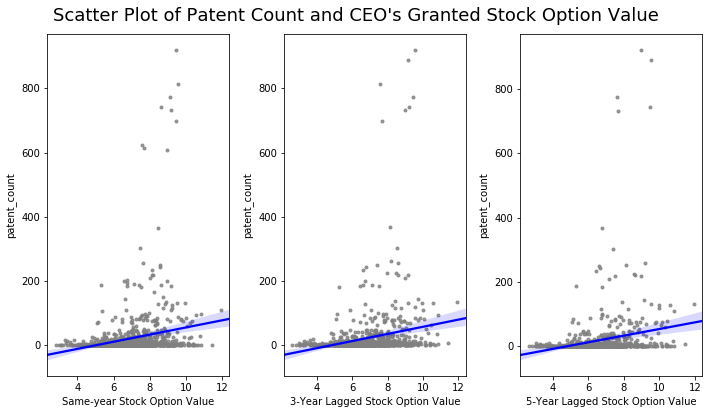

In [33]:
import seaborn as sns

fig, ax = plt.subplots(1,3, figsize=(10, 6))

sns.regplot(x='log_blkshval', y='patent_count', data=pat35, 
            scatter_kws={"color": "grey"}, line_kws={"color": "blue"},marker='.', ax=ax[0])

sns.regplot(x='log_blkshval3', y='patent_count', data=pat35, 
            scatter_kws={"color": "grey"}, line_kws={"color": "blue"},marker='.', ax=ax[1])

sns.regplot(x='log_blkshval5', y='patent_count', data=pat35, 
            scatter_kws={"color": "grey"}, line_kws={"color": "blue"}, marker='.', ax=ax[2])

ax[0].set_xlabel("Same-year Stock Option Value")
ax[1].set_xlabel("3-Year Lagged Stock Option Value")
ax[2].set_xlabel("5-Year Lagged Stock Option Value")

fig.suptitle('Scatter Plot of Patent Count and CEO\'s Granted Stock Option Value', fontsize=18)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

#### Specification 1 - Placebo Test 
(same-year stock option value)

In [34]:
from statsmodels.formula.api import ols

# generate log measure of company value
pat35['log_value'] = np.log(pat35['value'].replace(0, np.nan))

# we include company dummies (as firm-level fixed effect) and company value as control variable

robust_ols1 = ols('patent_count ~ C(gvkey) + log_blkshval + log_value', data=pat35).fit(cov_type='HC3') 
# HC3 stands for robust standard error used in this regression


print('Sample Coefficient for log_blkshval is', robust_ols1.params[113])
print('P-value for log_blkshval coefficient is', robust_ols1.pvalues[113])

Sample Coefficient for log_blkshval is 1.2010316064564557
P-value for log_blkshval coefficient is 0.1804166169344401


#### Specification 2 - Baseline Regression
(3-year lagged stock option value)

In [35]:
robust_ols2 = ols('patent_count ~ C(gvkey) + log_blkshval3 + log_value', data=pat35).fit(cov_type='HC3')
print('Sample Coefficient for log_blkshval3 is', robust_ols2.params[113])
print('P-value for log_blkshval3 coefficient is', robust_ols2.pvalues[113])

Sample Coefficient for log_blkshval3 is 1.565737885158954
P-value for log_blkshval3 coefficient is 0.0032442725179993898


#### Specification 3 
(5-year lagged stock option value)

In [36]:
robust_ols3 = ols('patent_count ~ C(gvkey) + log_blkshval5 + log_value', data=pat35).fit(cov_type='HC3')
print('Sample Coefficient for log_blkshval5 is', robust_ols3.params[113])
print('P-value for log_blkshval5 coefficient is', robust_ols3.pvalues[113])

Sample Coefficient for log_blkshval5 is 1.3594838259327475
P-value for log_blkshval5 coefficient is 0.018357035129659836


#### Interpretation

From the regression results, we can see that our placebo test is satisfied in Specification 1; while our results remain robust across two specifications of lagged measure of CEO's granted stock option value. 

To interpret our result from the baseline regression, we can see that coefficient of 3-year lagged measure of CEO's stock option value is 1.566, that is controlling for company value and firm-fixed effect, every 10% increase in CEO's stock option value is associated with 0.0156 unit increase in granted patent count 3 years after. This result is significant at 1% siginificance level   

### Prediction (Lasso)

I would like to predict company's patent count using baseline specification of CEO's granted stock option value, i.e. 3-year lagged measure of CEO's granted stock option value

In [37]:
from sklearn import (linear_model, model_selection, metrics)
from sklearn.preprocessing import Imputer 

In [38]:
pat35.head()

,gvkey,gyear,patent_count,year,blkshval,reload,co_per_rol,grntnum,numsecur,pcttotopt,...,ticker,naics,sic,sector,blkshval3,blkshval5,log_blkshval,log_blkshval3,log_blkshval5,log_value
3,1004,1995,3.0,1995,325.076,0.0,5623.0,1.0,75.0,26.05,...,AIR,423860.0,5080.0,Wholesale Trade,NaN,NaN,5.784059,NaN,NaN,6.715897
4,1004,1996,0.0,1996,1443.320,0.0,5623.0,1.0,200.0,32.08,...,AIR,423860.0,5080.0,Wholesale Trade,NaN,NaN,7.274701,NaN,NaN,7.830258
5,1004,1997,0.0,1997,2528.623,0.0,5623.0,1.0,150.0,16.84,...,AIR,423860.0,5080.0,Wholesale Trade,288.811,NaN,7.835430,5.665772,NaN,7.703844
6,1004,1998,0.0,1998,1644.472,0.0,5623.0,1.0,195.0,23.59,...,AIR,423860.0,5080.0,Wholesale Trade,325.076,NaN,7.405175,5.784059,NaN,7.767758
7,1004,1999,0.0,1999,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5080.0,Wholesale Trade,1443.320,288.811,NaN,7.274701,5.665772,NaN


In [39]:
# keep variables of interest only
pat35_ = pat35[['patent_count','log_blkshval', 'log_blkshval3', 'log_blkshval5','log_value']]

# Creating dummy variables for gvkey
gvkey = pat35['gvkey']
company = pd.get_dummies(data=gvkey, drop_first=True) # we drop first dummy to avoid dummy variable trap

# add gvkey dummies to the dataframe
pat35_dm = pd.concat([pat35_, company], axis=1, join='inner')

pat35_dm.head()

,patent_count,log_blkshval,log_blkshval3,log_blkshval5,log_value,1013,1078,1281,1380,1447,...,30990,31166,31600,61355,61401,64356,65142,65156,65739,66032
3,3.0,5.784059,NaN,NaN,6.715897,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,7.274701,NaN,NaN,7.830258,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0.0,7.835430,5.665772,NaN,7.703844,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0.0,7.405175,5.784059,NaN,7.767758,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0.0,NaN,7.274701,5.665772,NaN,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
# X variable
X = pat35_dm.drop(['patent_count'], axis=1).copy()

# Y variable
y = pat35_dm['patent_count']


# Transform the inputs
X1 = Imputer().fit_transform(X)

lr_model = linear_model.LinearRegression()
lasso_model = linear_model.Lasso()

lr_model.fit(X1,y)
lasso_model.fit(X1, y)

lasso_coef = lasso_model.coef_.tolist()
lr_coef = lr_model.coef_.tolist()

lasso_coefs = pd.Series(dict(zip(list(X.columns), lasso_coef)))
lr_coefs = pd.Series(dict(zip(list(X.columns), lr_coef)))
coefs = pd.DataFrame(dict(lasso=lasso_coefs, linear_reg=lr_coefs))
coefs

/opt/conda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


,lasso,linear_reg
log_blkshval,1.470852,1.199849
log_blkshval3,3.178929,1.902943
log_blkshval5,2.388448,2.318076
log_value,2.124837,0.100011
1013,0.000000,46.847985
1078,0.000000,118.506054
1281,-0.000000,6.396107
1380,-0.000000,-2.198670
1447,-0.000000,-5.484581
1661,-0.000000,-8.417164


#### Cross-Validation

In [46]:

X_train, X_test, y_train, y_test = model_selection.train_test_split(X1, y, test_size=0.2)

lasso = linear_model.LassoCV(cv=5).fit(X_train,y_train)

lasso_model_op = linear_model.Lasso(alpha=lasso.alpha_)
lasso_model_op.fit(X1, y)

lasso_op_coef = lasso_model_op.coef_.tolist()

lasso_op_coefs = pd.Series(dict(zip(list(X.columns), lasso_op_coef)))
lasso_coefs = pd.Series(dict(zip(list(X.columns), lasso_coef)))
lr_coefs = pd.Series(dict(zip(list(X.columns), lr_coef)))

coefs = pd.DataFrame(dict(lasso_op=lasso_op_coefs, lasso=lasso_coefs, linreg=lr_coefs))
coefs

,lasso_op,lasso,linreg
log_blkshval,0.713116,1.470852,1.199849
log_blkshval3,1.612388,3.178929,1.902943
log_blkshval5,1.901507,2.388448,2.318076
log_value,-0.000000,2.124837,0.100011
1013,39.821478,0.000000,46.847985
1078,112.636617,0.000000,118.506054
1281,0.000000,-0.000000,6.396107
1380,-4.592643,-0.000000,-2.198670
1447,-6.991575,-0.000000,-5.484581
1661,-9.304681,-0.000000,-8.417164


#### Report Mean Square Error

In [47]:
# lasso regression with optimal alpha
mse_lasso_op = metrics.mean_squared_error(y, lasso_model_op.predict(X1))
print('mse for lasso with optimal alpha is', mse_lasso_op)

# lasso regression
mse_lasso = metrics.mean_squared_error(y, lasso_model.predict(X1))
print('mse for lasso regression is', mse_lasso)

# linear regression
mse_linear = metrics.mean_squared_error(y, lr_model.predict(X1))
print('mse for linear regression is', mse_linear)

mse for lasso with optimal alpha is 242.4160769514998
mse for lasso regression is 1001.1142539255462
mse for linear regression is 238.43091065398735


### Conclusion

From our prediction results, we can see that it seems that our features do not posses large predictive power in predicting number of patent counted for a company (other classification were tested, however, mean squared error remain to be large). Nonetheless, we find robust and significant correlation between CEO's granted stock option value and number of granted patents for a company. Findings in this study offer the empirical evidence in support of the theory in coporate finance literature: the 
compensation scheme that rewards for the long-term success and indicates the commitment to a long-term compensation plan to CEOs, are essential to motivating innovation at the firm level. 
